## Esercizio su ML, nuclei instabili

In [1]:
import ROOT as R
import plotly.express as px
import numpy as np
import scipy
import math
from tqdm import tqdm
import time
import array
%jsroot off

Welcome to JupyROOT 6.16/00


In [2]:
class MLK_method:
    def __init__(self,sigma_t,tau):
        self.data_list=[]
        self.sigma_t=sigma_t
        self.tau = tau
        
    def PDF(self,x,tau,sigma_t):
        """
        PDF come descritta nelle slide
        """
        try:
            toreturn=R.TMath.Exp((sigma_t**2-2*x*tau)/(2*tau**2))*R.Math.erfc((sigma_t**2-x*tau)/(2**(1/2)*tau*sigma_t))/(2*tau)
        except:
            """ Ho dovuto gestire l'eccezione (un po' brutalmente) perchè il TF2.GetMaximum che uso nel countour plot ci tiene a tutti i costi a valutare la 
            funzione anche vicino allo zero (nonostante sia fuori dal range)."""
            pass
            toreturn = 0.0001
        return toreturn

    def gen_acc_rej(self, points=10000000,seed=12, nbins=1000):
        """
        Genero i punti tramite il metodo acceptance-rejecton. Per i dettagli rimando all'altro esercizio
        """
        self.func=R.TF1("PDF",lambda x : self.PDF(x[0],self.tau,self.sigma_t),-10, 10 ,0)
        start=time.time()
        if seed==0:
            """ Con seed==0 uso il tempo come seed"""
            rand=R.TRandom3(int(time.time()))
        else:
            rand=R.TRandom3(seed)
        max_ = self.func.GetMaximum()
        h_generated = R.TH1F("h_generated","Generated lifetimes",nbins,-10,10)
        z=0
        while z<points:
            rand_num=rand.Rndm()
            r1=rand.Rndm()*20-10
            r2=rand.Rndm()
            if r2<self.func.Eval(r1)/max_:
                h_generated.Fill(r1)
                z+=1
                
        end=time.time()
        elapsed_time=end-start
        self.h_generated=h_generated
        self.c=R.TCanvas()
        h_generated.Draw()
        self.c.Draw()

    def gauss_smearing(self,histo,sigma,seed):
        """
        Un semplice gaussian smearing. Uso la funzione di root rand.gauss per generare uno shift da aggiungere a ogni entry dell'istogramma generato sopra
        """
        data_list=[]
        if seed==0:
            rand=R.TRandom3(int(time.time()))
        else:
            rand=R.TRandom3(seed)
        for num in range(0,histo.GetNbinsX()):
            pos_x=histo.GetBinCenter(num)
            iterations=int(histo.GetBinContent(num))
            for i in range (0,iterations):
                data_list.append(pos_x+rand.Gaus(0,sigma))
                """
                Metto i dati in una lista per calcolarci poi la likelyhood
                """
        self.data_list=data_list
    
    def lg_likelyhood(self,x):
        """
        Calcola la log likelyhood della lista di punti generata prima
        """
        to_return=0
        for elem in self.data_list:
            to_return+=math.log(self.PDF(elem,x[0],self.sigma_t))
        return to_return
    
    def lg_likelyhood_2D(self,x):
        """
        Calcola la log likelyhood della lista di punti generata prima per entrambe le variabili (tau e sigma_t)
        """
        to_return=0
#         if x[0]==0 or x[1]==0:
#             return -500
        for elem in self.data_list:
            to_return+=math.log(self.PDF(elem,x[0],x[1]))
        return to_return
    
    def plot_likelyhood(self):
        """
        Mostra la likelyhood e calcola la sigma del valore stimato, usando il metodo di log likelyhood max +/- 0.5
        """
        self.F_lk=R.TF1("likelyhood",self.lg_likelyhood,0.1,4)
        self.c2=R.TCanvas()
        self.F_lk.Draw()
        self.c2.Draw()
        self.tau_found=self.F_lk.GetMaximumX()
        sigma_tau_plus=self.F_lk.GetMaximumX()-self.F_lk.GetX(self.F_lk.GetMaximum()-0.5,self.F_lk.GetMaximumX()-0.5,self.F_lk.GetMaximumX())
        sigma_tau_minus=self.F_lk.GetMaximumX()-self.F_lk.GetX(self.F_lk.GetMaximum()-0.5,self.F_lk.GetMaximumX())
        self.sigma_tau=np.average((abs(sigma_tau_minus),abs(sigma_tau_plus)))
        self.c3=R.TCanvas()
        self.h_scaled=self.h_generated.Clone()
        self.h_scaled.SetTitle("Generated lifetimes with PDF")
        self.h_scaled.Scale(self.func.Integral(-10,10)/(self.h_generated.Integral()*self.h_generated.GetBinWidth(2)))
        self.h_scaled.Draw("histo")
        self.func.SetRange(-10,10)
        self.func.Draw("same")
        self.c3.Draw()

    def countour_plot(self):
        """
        Costruisce un color plot e traccia le linee di contorno per i valori a 1,2 e 3 sigma.
        """
        self.c.cd()
        self.F_lk_2VAR= R.TF2("likelyhood_2D",self.lg_likelyhood_2D,0.5,1.5,0.2,1)
        self.F_lk_2VAR.Draw("colz")
        self.F_lk_countour=self.F_lk_2VAR.Clone()
        self.F_lk_countour.SetLineColor(1)
        self.F_lk_countour.SetLineStyle(1)
        self.F_lk_countour.SetNpx(50)
        self.F_lk_countour.SetNpy(50)
        c_count=self.F_lk_2VAR.GetMaximum(array.array('d',[1,0.5]))-0.5
        b_count=self.F_lk_2VAR.GetMaximum(array.array('d',[1,0.5]))-1
        a_count=self.F_lk_2VAR.GetMaximum(array.array('d',[1,0.5]))-1.5
        c_levels=array.array('d',[a_count,b_count,c_count])
        self.F_lk_countour.SetContour(3,c_levels)
        self.F_lk_countour.Draw("cont3 same")
        self.c.Draw()


 Istanzio la classe per $\sigma_t=0.5$ e $\tau=1$

In [3]:
MLK_istance=MLK_method(0.5,1)

Faccio un primo esperimento con 1000 eventi

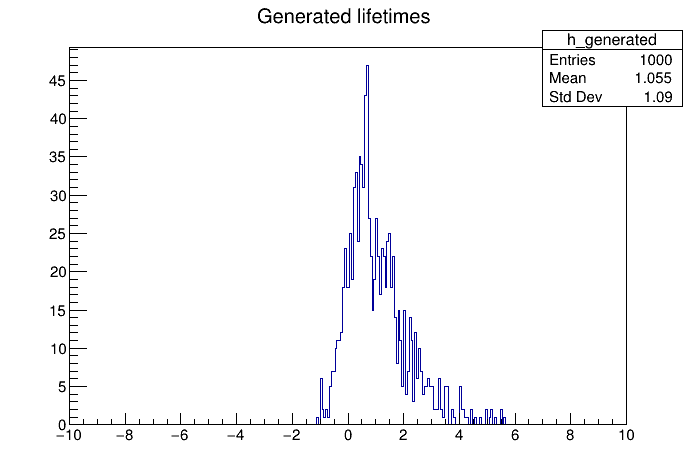

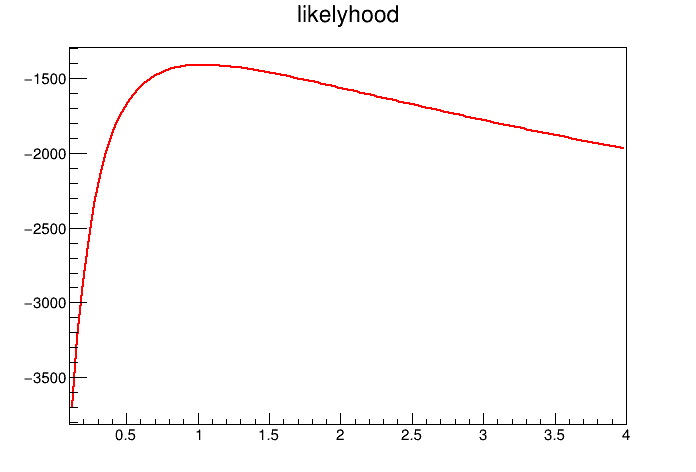

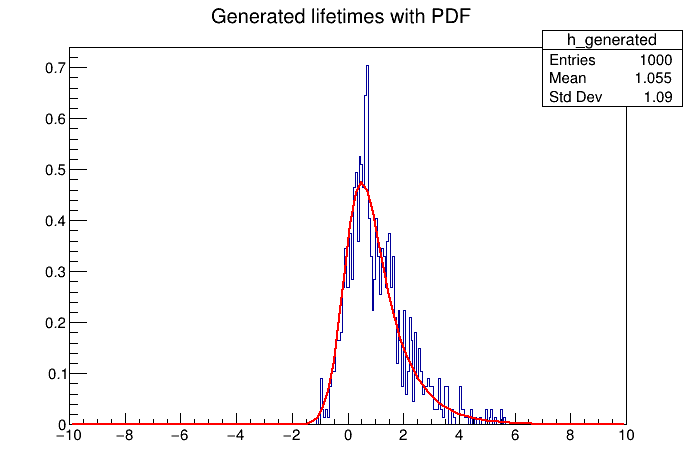

In [4]:
MLK_istance.gen_acc_rej(1000,0,300)
MLK_istance.gauss_smearing(MLK_istance.h_generated,0.1,0)
MLK_istance.plot_likelyhood()

In [5]:
print ("Tau={:.3f}  sigma_tau={:.3f}".format(MLK_istance.tau_found, MLK_istance.sigma_tau))

Tau=1.044  sigma_tau=0.035


## Ora faccio 100 esperimenti da 200 eventi ciascuno

100%|██████████| 100/100 [01:17<00:00,  1.06it/s]
Warning in <TROOT::Append>: Replacing existing TH1: h_generated (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_generated (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_generated (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_generated (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_generated (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_generated (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_generated (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_generated (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_generated (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_generated (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_genera

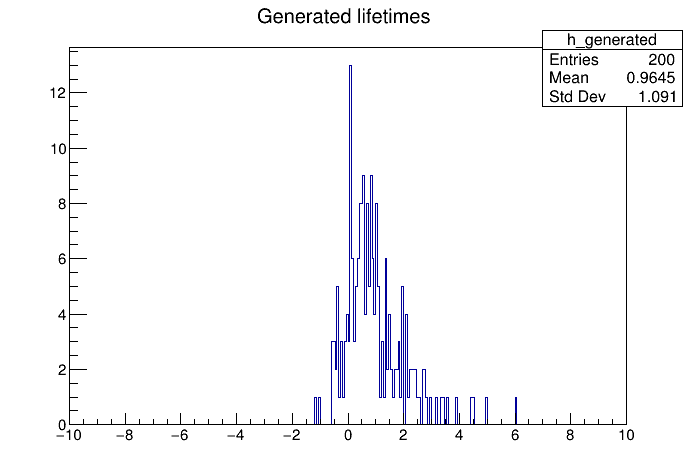

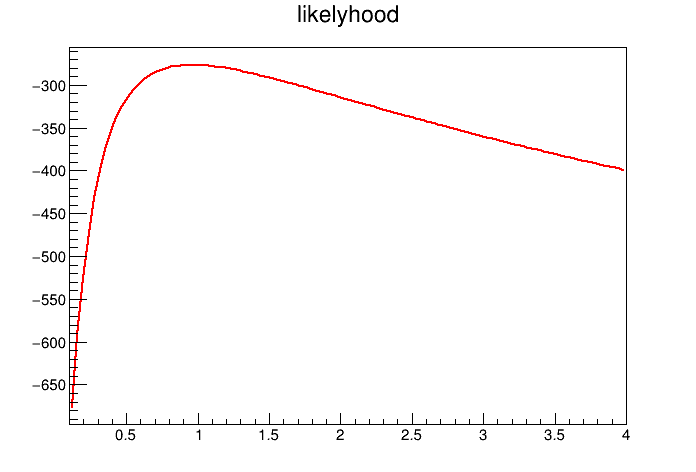

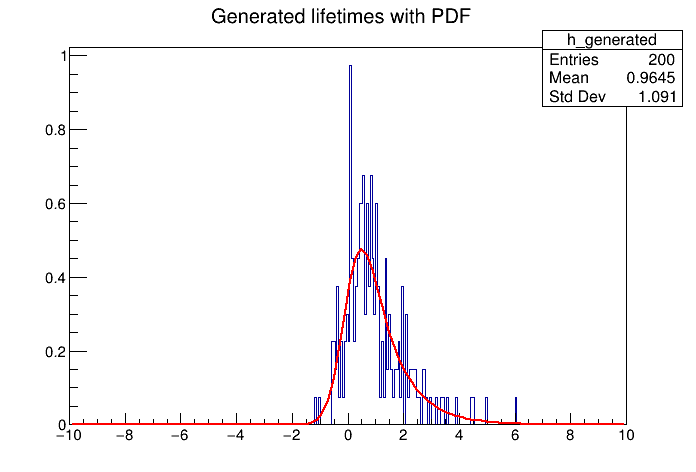

In [6]:
h_pull=R.TH1F("h_rep","residuals",100,-10,10)
for rep in tqdm(range(0,100)):
    MLK_istance.gen_acc_rej(200,0,300)
    MLK_istance.gauss_smearing(MLK_istance.h_generated,0.1,0)
    MLK_istance.plot_likelyhood()
    h_pull.Fill((MLK_istance.tau_found-MLK_istance.tau)/MLK_istance.sigma_tau)

Plottando i residui

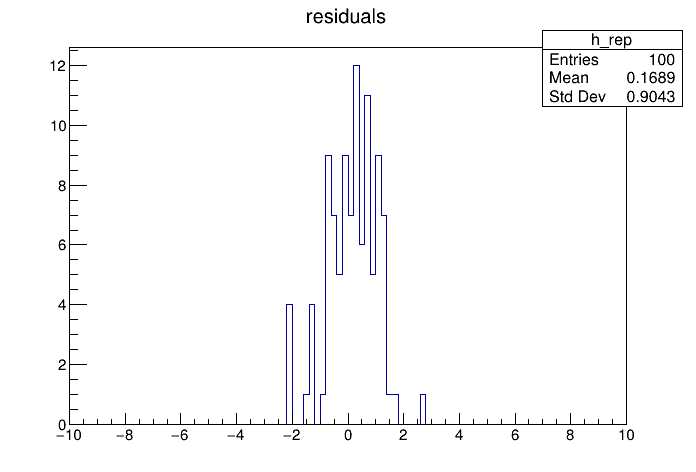

In [7]:
c=R.TCanvas()
h_pull.Draw()
c.Draw()

Il residuo ha media compatibile con zero e Deviazione Standard compatibile con 1.

Disegno il plot richiesto per l'ultimo esperimento generato

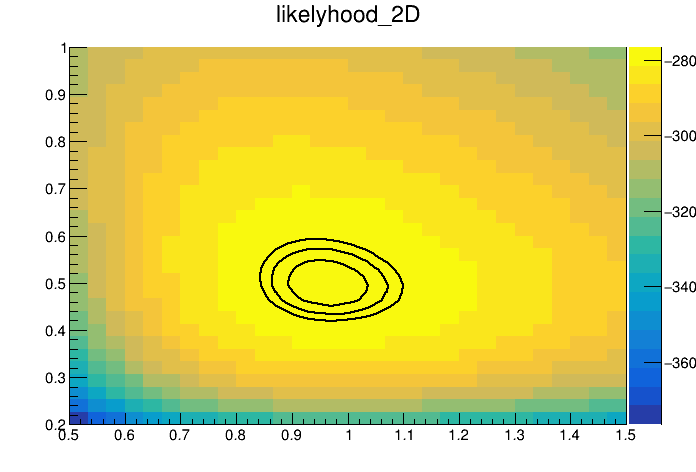

In [8]:
MLK_istance.countour_plot()
